<a href="https://colab.research.google.com/github/soucs/ac-gans/blob/main/ac_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import CIFAR10

In [2]:
transform = Compose([ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                     ])

batch_size = 100

train = CIFAR10(root='./data', train=True, download=True, transform=transform)
test = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test, batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_classes = 10
batch_size = 100
latent_size = 100

def get_z(classes):
  z = torch.randn(batch_size, latent_size)
  y = one_hot(classes.reshape(batch_size), num_classes)
  z = torch.cat([z, y], dim=1).reshape(-1,110,1,1)
  return z

In [4]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    def discriminator_block(inp, out, stride, bn=True):
      block = [nn.Conv2d(inp, out, 3, stride, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.5)]
      if bn:
        block.append(nn.BatchNorm2d(out, 0.8))
      return block
    self.common = nn.Sequential(*discriminator_block(3, 16, 2, bn=False),
                                *discriminator_block(16, 32, 1),
                                *discriminator_block(32, 64, 2),
                                *discriminator_block(64, 128, 1),
                                *discriminator_block(128, 256, 2),
                                *discriminator_block(256, 512, 1))
    self.discrim = nn.Sequential(nn.Linear(512*4*4, 1),
                                 nn.Sigmoid())
    self.auxil = nn.Sequential(nn.Linear(512*4*4, 10),
                               nn.Softmax(dim=1))
  def forward(self, input): # input = images (batch_size, 3, 32, 32)
    hid_out = self.common(input)
    hid_out = hid_out.view(hid_out.size(0), -1)
    rf_out = self.discrim(hid_out)
    aux_out = self.auxil(hid_out)
    return rf_out, aux_out

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    def generator_block(inp, out, nonlin='relu', bn=True):
      block = [nn.ConvTranspose2d(inp, out, 5, 2, 1)]
      if nonlin == 'tanh':
        block.append(nn.Tanh())
      else:
        block.append(nn.ReLU())
      if bn:
          block.append(nn.BatchNorm2d(out, 0.8))
      return block
    self.gen = nn.Sequential(*generator_block(110,384),
                             *generator_block(384,192),
                             *generator_block(192,96),
                             *generator_block(96,3, nonlin='tanh', bn=False),
                             nn.UpsamplingBilinear2d((32,32)))
  def forward(self, input): # input = classes (batch_size)
    z = get_z(input) # z = latent space (batch_size, 110, 1, 1)
    fake_img = self.gen(z)
    return fake_img

In [5]:
D = Discriminator()
G = Generator()

criterion = nn.BCELoss()
aux_criterion = nn.CrossEntropyLoss()

d_optimizer = Adam(D.parameters(), lr=0.0002)
g_optimizer = Adam(G.parameters(), lr=0.0002)

def train_discriminator(images,classes):
    real_labels = torch.ones(batch_size,1)
    fake_labels = torch.zeros(batch_size,1)

    rf_out, aux_out = D(images)
    d_loss_real = criterion(rf_out, real_labels)
    d_loss_rclass = aux_criterion(aux_out, classes)

    fake_images = G(classes)
    rf_out, aux_out = D(fake_images)
    d_loss_fake = criterion(rf_out, fake_labels)
    d_loss_fclass = aux_criterion(aux_out, classes)

    # Combine losses
    Ls = d_loss_real + d_loss_fake
    Lc = d_loss_rclass + d_loss_fclass
    d_loss = Lc + Ls

    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    return d_loss

def train_generator(classes):
    real_labels = torch.ones(batch_size,1)

    fake_images = G(classes)
    rf_out, aux_out = D(fake_images)

    g_loss_fake = criterion(rf_out, real_labels)
    g_loss_fclass = aux_criterion(aux_out, classes)

    # Combine losses
    g_loss = g_loss_fake + g_loss_fclass

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss

def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

Saving fake_images-0000.png


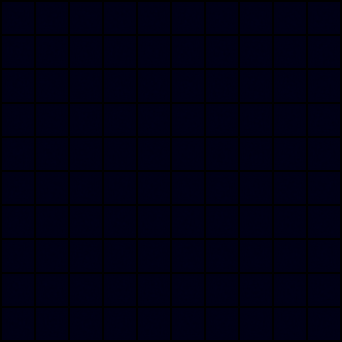

In [6]:
import os
from IPython.display import Image
from torchvision.utils import save_image

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

for i, classes in train_dl:
    # sample_vectors = get_z(classes)
    break

def save_fake_images(index):
    fake_images = G(classes)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 32, 32)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=10)

# # Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
num_epochs = 20
total_step = len(train_dl)

for epoch in range(num_epochs):
    for i, (images, classes) in enumerate(train_dl):
      if i==20:
        break
      d_loss = train_discriminator(images, classes)
      g_loss = train_generator(classes)
    print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))
    save_fake_images(epoch+1)

Epoch [1/20], Step [21/500], d_loss: 5.9402, g_loss: 2.9832
Saving fake_images-0001.png
Epoch [2/20], Step [21/500], d_loss: 5.8714, g_loss: 2.8569
Saving fake_images-0002.png
Epoch [3/20], Step [21/500], d_loss: 5.8390, g_loss: 3.6500
Saving fake_images-0003.png
Epoch [4/20], Step [21/500], d_loss: 5.8532, g_loss: 3.4279
Saving fake_images-0004.png
Epoch [5/20], Step [21/500], d_loss: 5.5706, g_loss: 4.0778
Saving fake_images-0005.png
Epoch [6/20], Step [21/500], d_loss: 5.6162, g_loss: 4.3935
Saving fake_images-0006.png
Epoch [7/20], Step [21/500], d_loss: 5.3896, g_loss: 4.1059
Saving fake_images-0007.png
Epoch [8/20], Step [21/500], d_loss: 5.7138, g_loss: 3.4935
Saving fake_images-0008.png


In [ ]:
import cv2
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')